# <center>Down-and-out Barrier Call Option Pricing<center>

## <p style="text-align: right;">Yuqian Li</p>

We would like to price a down-and-out call.

Given a maturity time $T$, a stock price $S_t$, a strike $K$ and a barrier $B$, the option pays $(S_T − K)^+$ only if $S_u \ge B$ for all $u \in (t, T)$.
The interest rate $r$ is constant, $S_t$ starts at $x > B$ and follows a Geometric Brownian Motion in the risk
neutral measure:

$$dS_t = rS_tdt + \sigma S_tdW_t$$

In all the numerical experiments, we will take $t = 0$ year, $T = 1$ year, $r = 0.02$ ($2\%$ per year), $\sigma = 0.20$ ($20\%$ per year), $x = 100\$$, $B = 80\$$, and $K = 110\$$.

The followings notes and codes present the 3 main approaches to price options:

 - Monte Carlo simulation
 - Finite Difference method of PDE
 - Closed-form analytical method of PDE

# <span style="color:blue">Method 1: Monte Carlo simulation</span>

## <span style="color:blue">(a)</span>

### <span style="color:blue">Explain that the value of the option should be $$V_t = e^{−r(T−t)}\mathbb{E}[(S_T − K)^+\mathbf{1}_{S_u \ge B,\forall u \in (t,T)}|\mathcal{F}_t]$$ where $\mathbb{E}$ is in the risk neutral measure.</span>

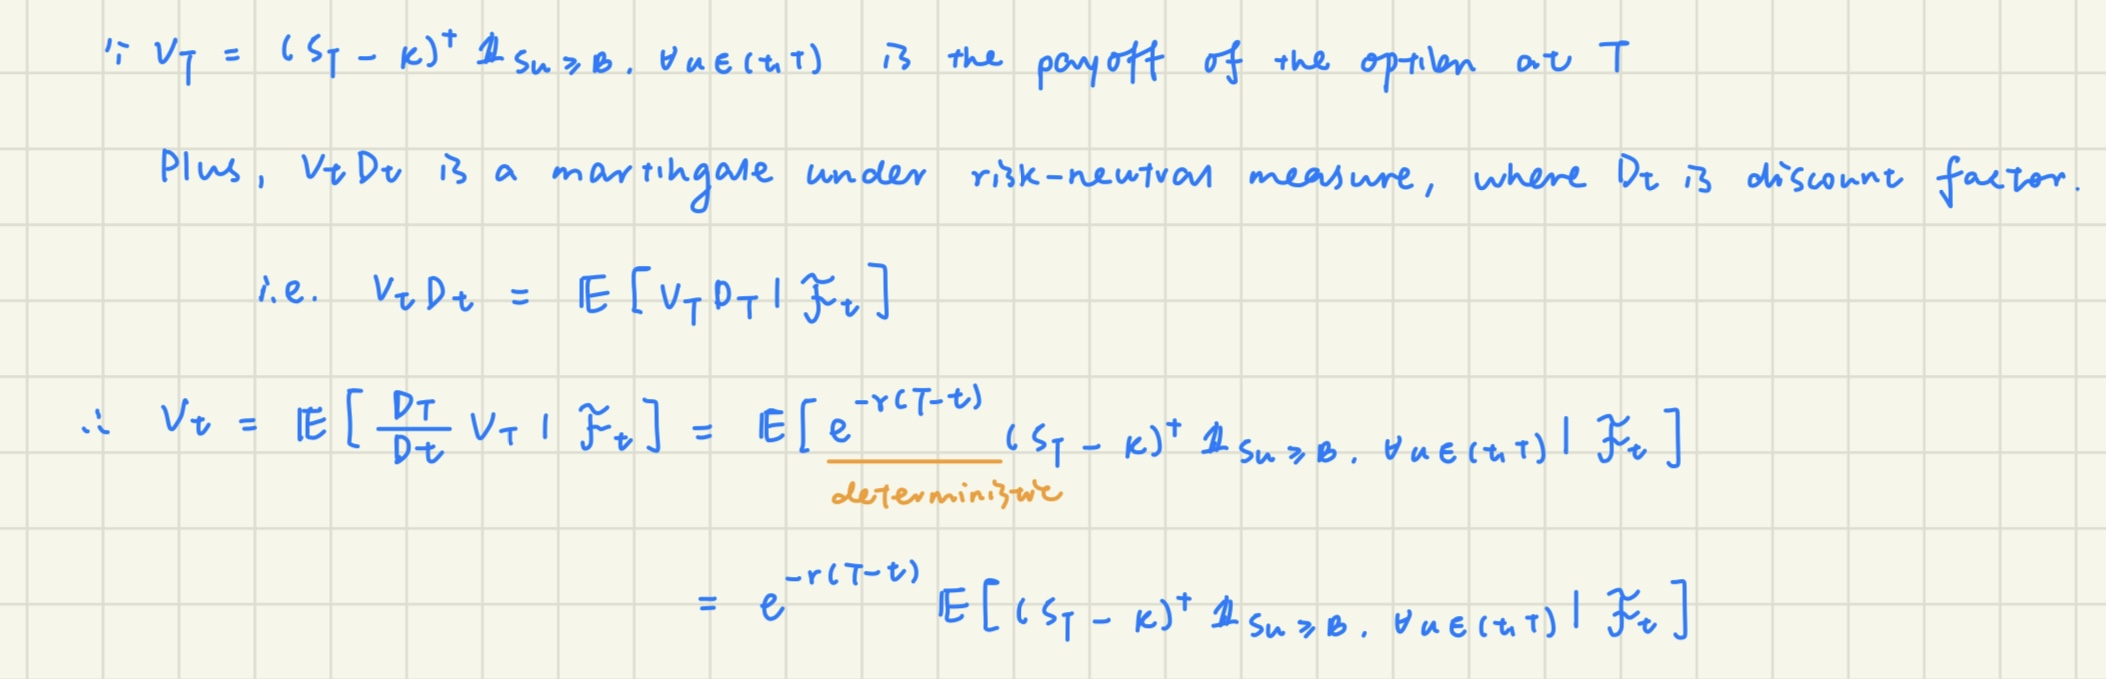

In [1]:
from IPython.display import Image
Image("1.jpg")

## <span style="color:blue">(b)</span>

### <span style="color:blue">Using the SDE, write a program that computes one trajectory of $S_t$ for $t < T$; it should return a list of values $S_0, S_{\Delta t}, S_{2 \Delta t}, ..., S_T$ for $\Delta T = \frac{T}{N}$ where $N$ is the number of points (you can choose N = 252 for example).</span>

In [2]:
def SGenerate(t,T,N,r,sigma,x):
    import numpy as np
    step = (T-t)/N
    S = x
    S_path = [S]
    for i in range(N):
        dw = np.random.normal(0, np.sqrt(step))
        dS = r*S*step+sigma*S*dw
        S += dS
        S_path.append(S) 
    return S_path

In [3]:
# example
SGenerate(0,1,252,0.02,0.2,100)

[100,
 98.05526282115818,
 96.32294833854226,
 97.30561781383513,
 93.4474106672994,
 91.56863192165316,
 90.9974925203219,
 90.40639941167733,
 91.12215004501502,
 92.09497552433979,
 92.08877601551708,
 92.5678181100674,
 89.77678929185596,
 89.88214254173923,
 90.2107302579397,
 90.91880970334549,
 91.09414901680093,
 90.61061952276121,
 91.61704855454008,
 92.14341657892406,
 91.91028509354517,
 91.65099277533501,
 89.67662326853193,
 86.5794600433056,
 87.44486951927631,
 85.43425146246004,
 83.51352731328721,
 85.08548076642548,
 85.60096942800902,
 84.86161434606625,
 84.70986771133748,
 84.88697387088258,
 85.12416259824617,
 84.60722667192454,
 84.75384377060446,
 84.06138949112453,
 83.34915882470914,
 82.36497229595075,
 82.57528845471647,
 83.135169020221,
 84.09567009278229,
 83.99960783883594,
 84.07488526942873,
 82.87720000068248,
 84.90230266499393,
 88.04439673898487,
 89.43528474892753,
 91.2111311013812,
 92.05452559105561,
 91.31292877434328,
 92.54968196442171,
 9

## <span style="color:blue">(c)</span>

### <span style="color:blue">Write a program that takes the list of values computed in the previous question and returns the payoff of the option $\phi(S) = (S_T − K)^+$ if all $S_{k \Delta t} > B$, and $0$ otherwise.</span>

In [4]:
def Payoff(t,T,N,r,sigma,x,B,K):
    S_path = SGenerate(t,T,N,r,sigma,x)
    if min(S_path) > B:
        return max(S_path[-1]-K,0),S_path
    else:
        return 0,S_path

In [5]:
# example
Payoff(0,1,252,0.02,0.2,100,80,110)[0]

36.56645312320762

## <span style="color:blue">(d)</span>

### <span style="color:blue">Using your previous code, write a program that generates $N_p = 10^6$ trajectories of $S$, and computes the average $$\frac{e^{-r(T-t)}}{N_p}\sum_{j=1}^{N_p}\phi(S^{(j)})$$ where $S^{(j)}$ is the $j^{th}$ trajectory. Deduce the price of the option.</span>

In [8]:
def MC(Np,t,T,N,r,sigma,x,B,K):
    import numpy as np
    payoffs = []
    price = 0
    for j in range(Np):
        payoff = Payoff(t,T,N,r,sigma,x,B,K)[0]
        price += payoff
        payoffs.append(payoff)
    price = price*np.exp(-r*(T-t))/Np
    return price,payoffs

In [15]:
import time
start_time = time.time()

print('The price by MC is:', MC(1000000,0,1,252,0.02,0.2,100,80,110)[0])

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Running time: {elapsed_time} second")

The price by MC is: 4.9333104196717645
Running time: 170.91788506507874 second


In [16]:
MC(1000000,0,1,252,0.02,0.2,100,80,110)[0]

4.945528169669314

In [17]:
MC(1000000,0,1,252,0.02,0.2,100,80,110)[0]

4.924920362005806

__Calculation result:__

__The Monte Carlo solution of the PDE is around 4.93. Since it is an average, expected, present value of multiple times of simulation, the result is a not fixed number. But it converges with accuracy to one decimal place.__

__Running time:__

__Very slow, taking around 170 seconds to simulate for 10^6 times.__

# <span style="color:blue">PDE Usage Preparation </span>

## <span style="color:blue">(e)~(i)</span>

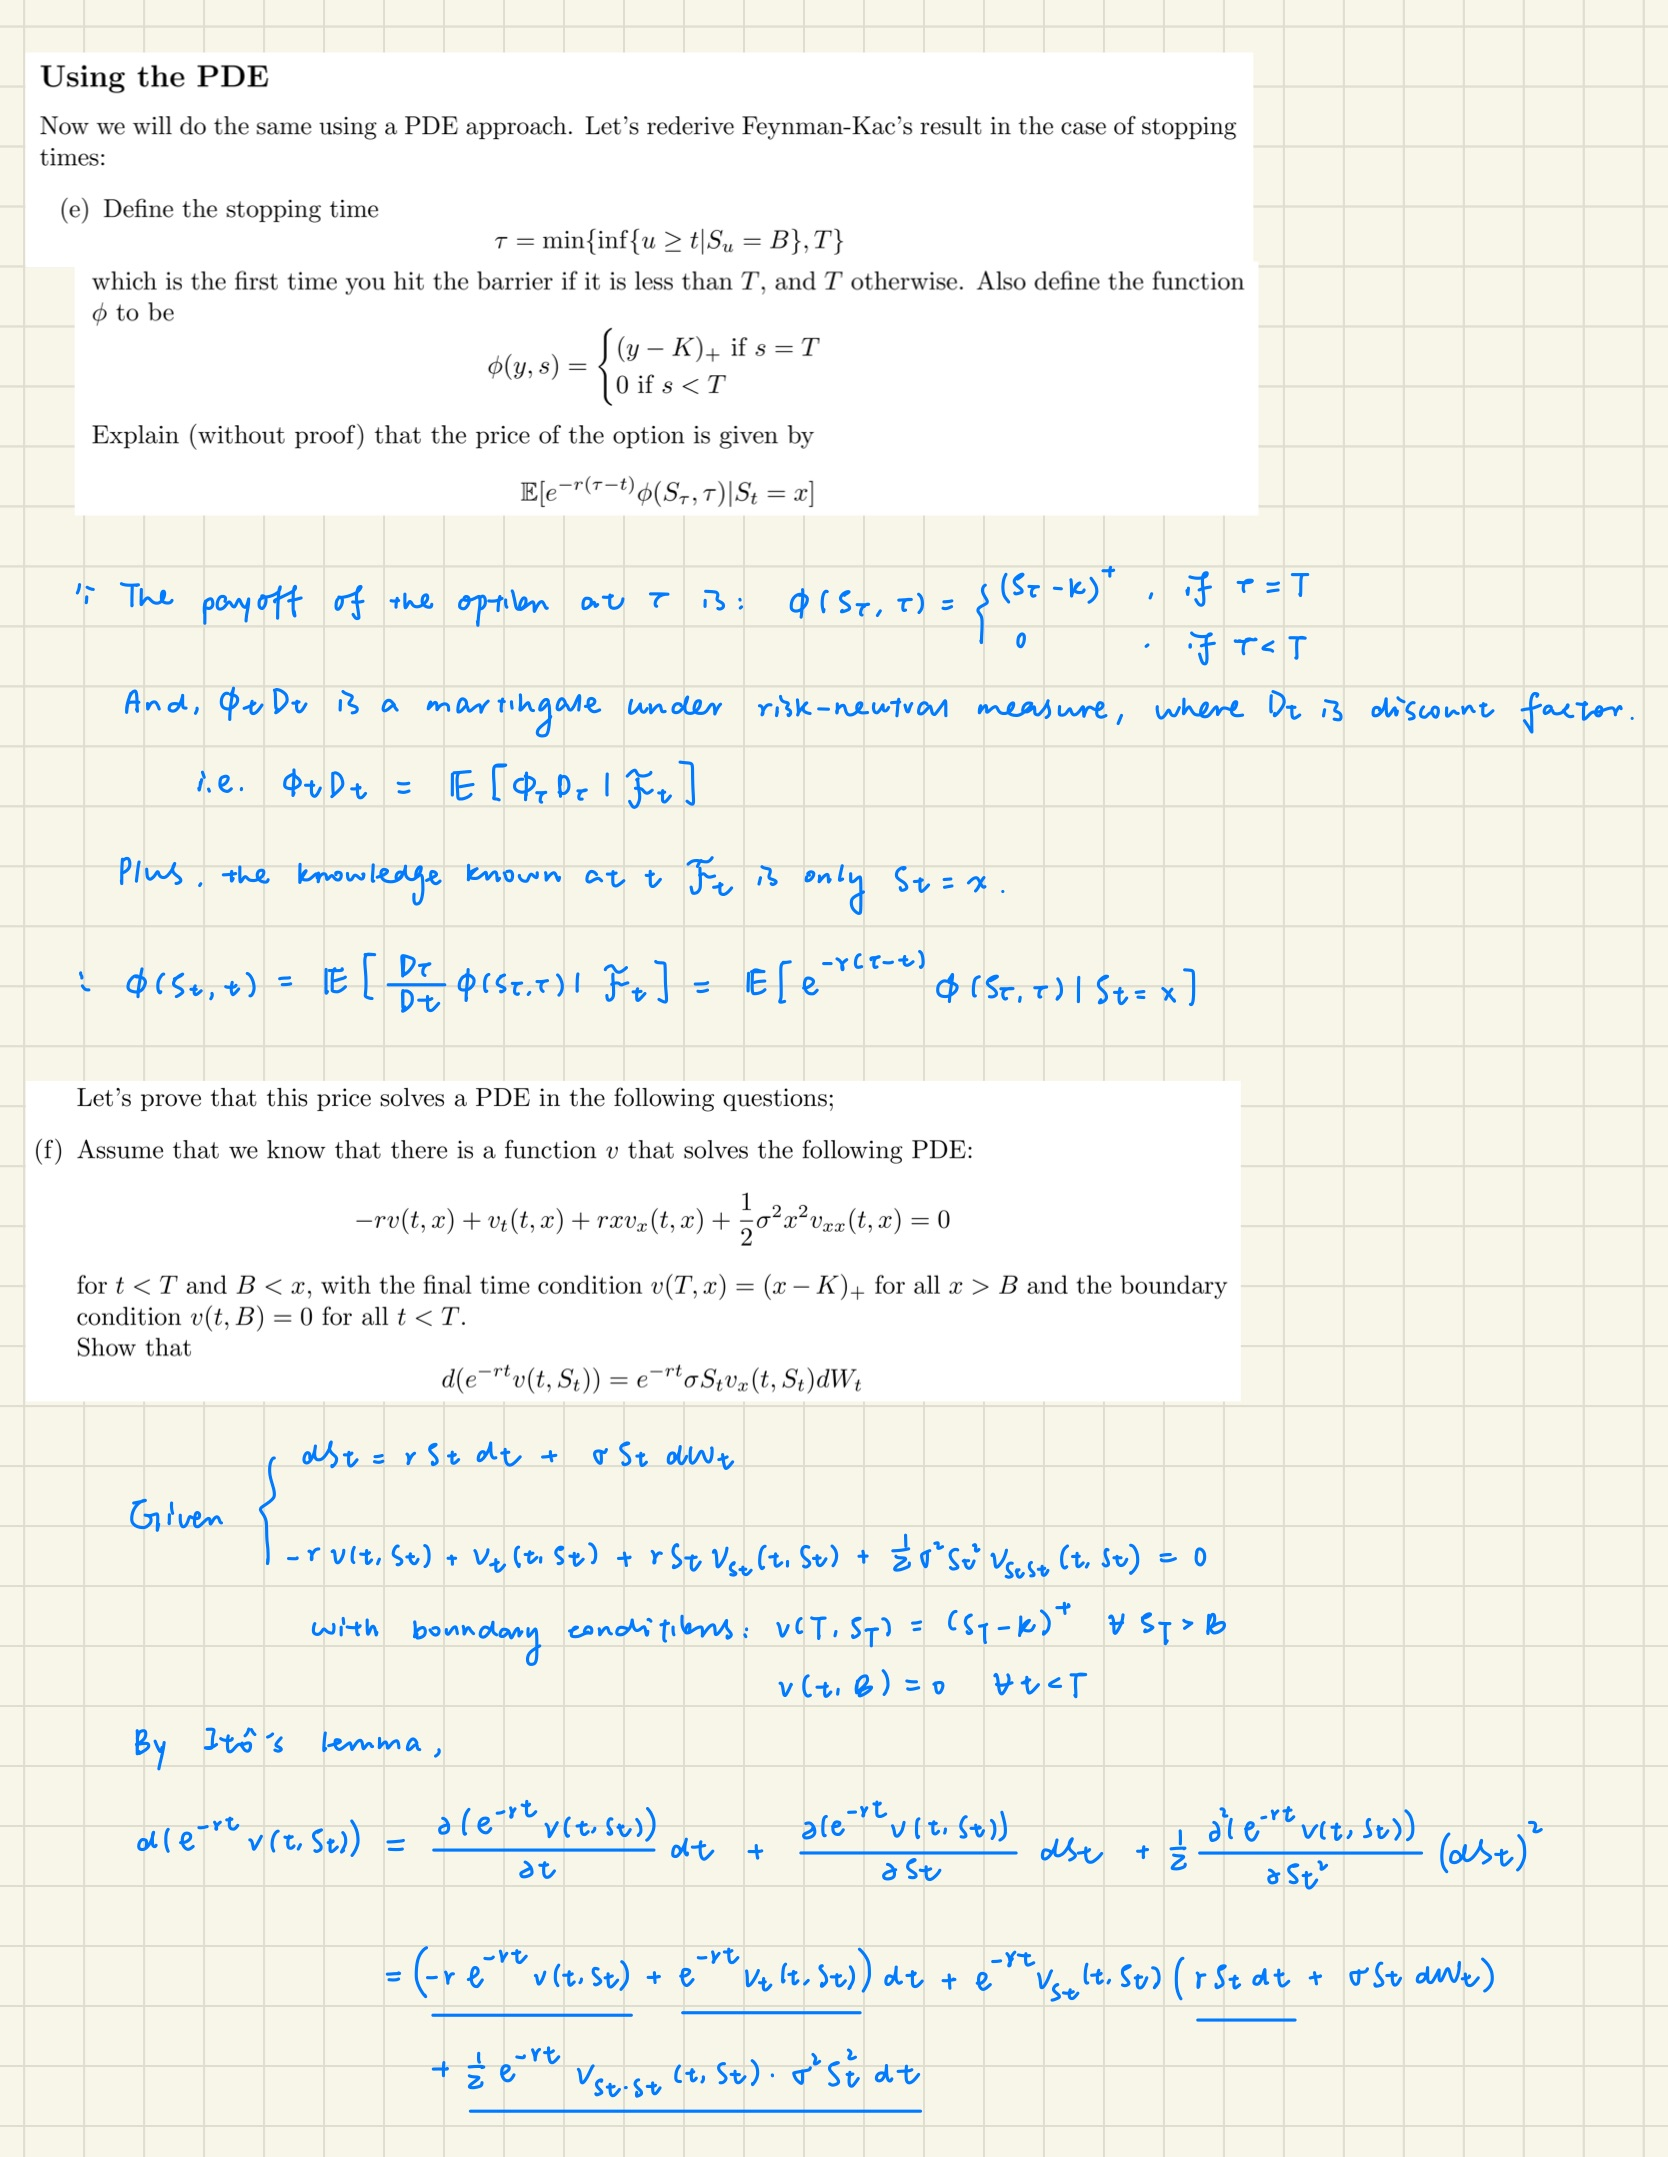

In [18]:
Image("2.jpg")

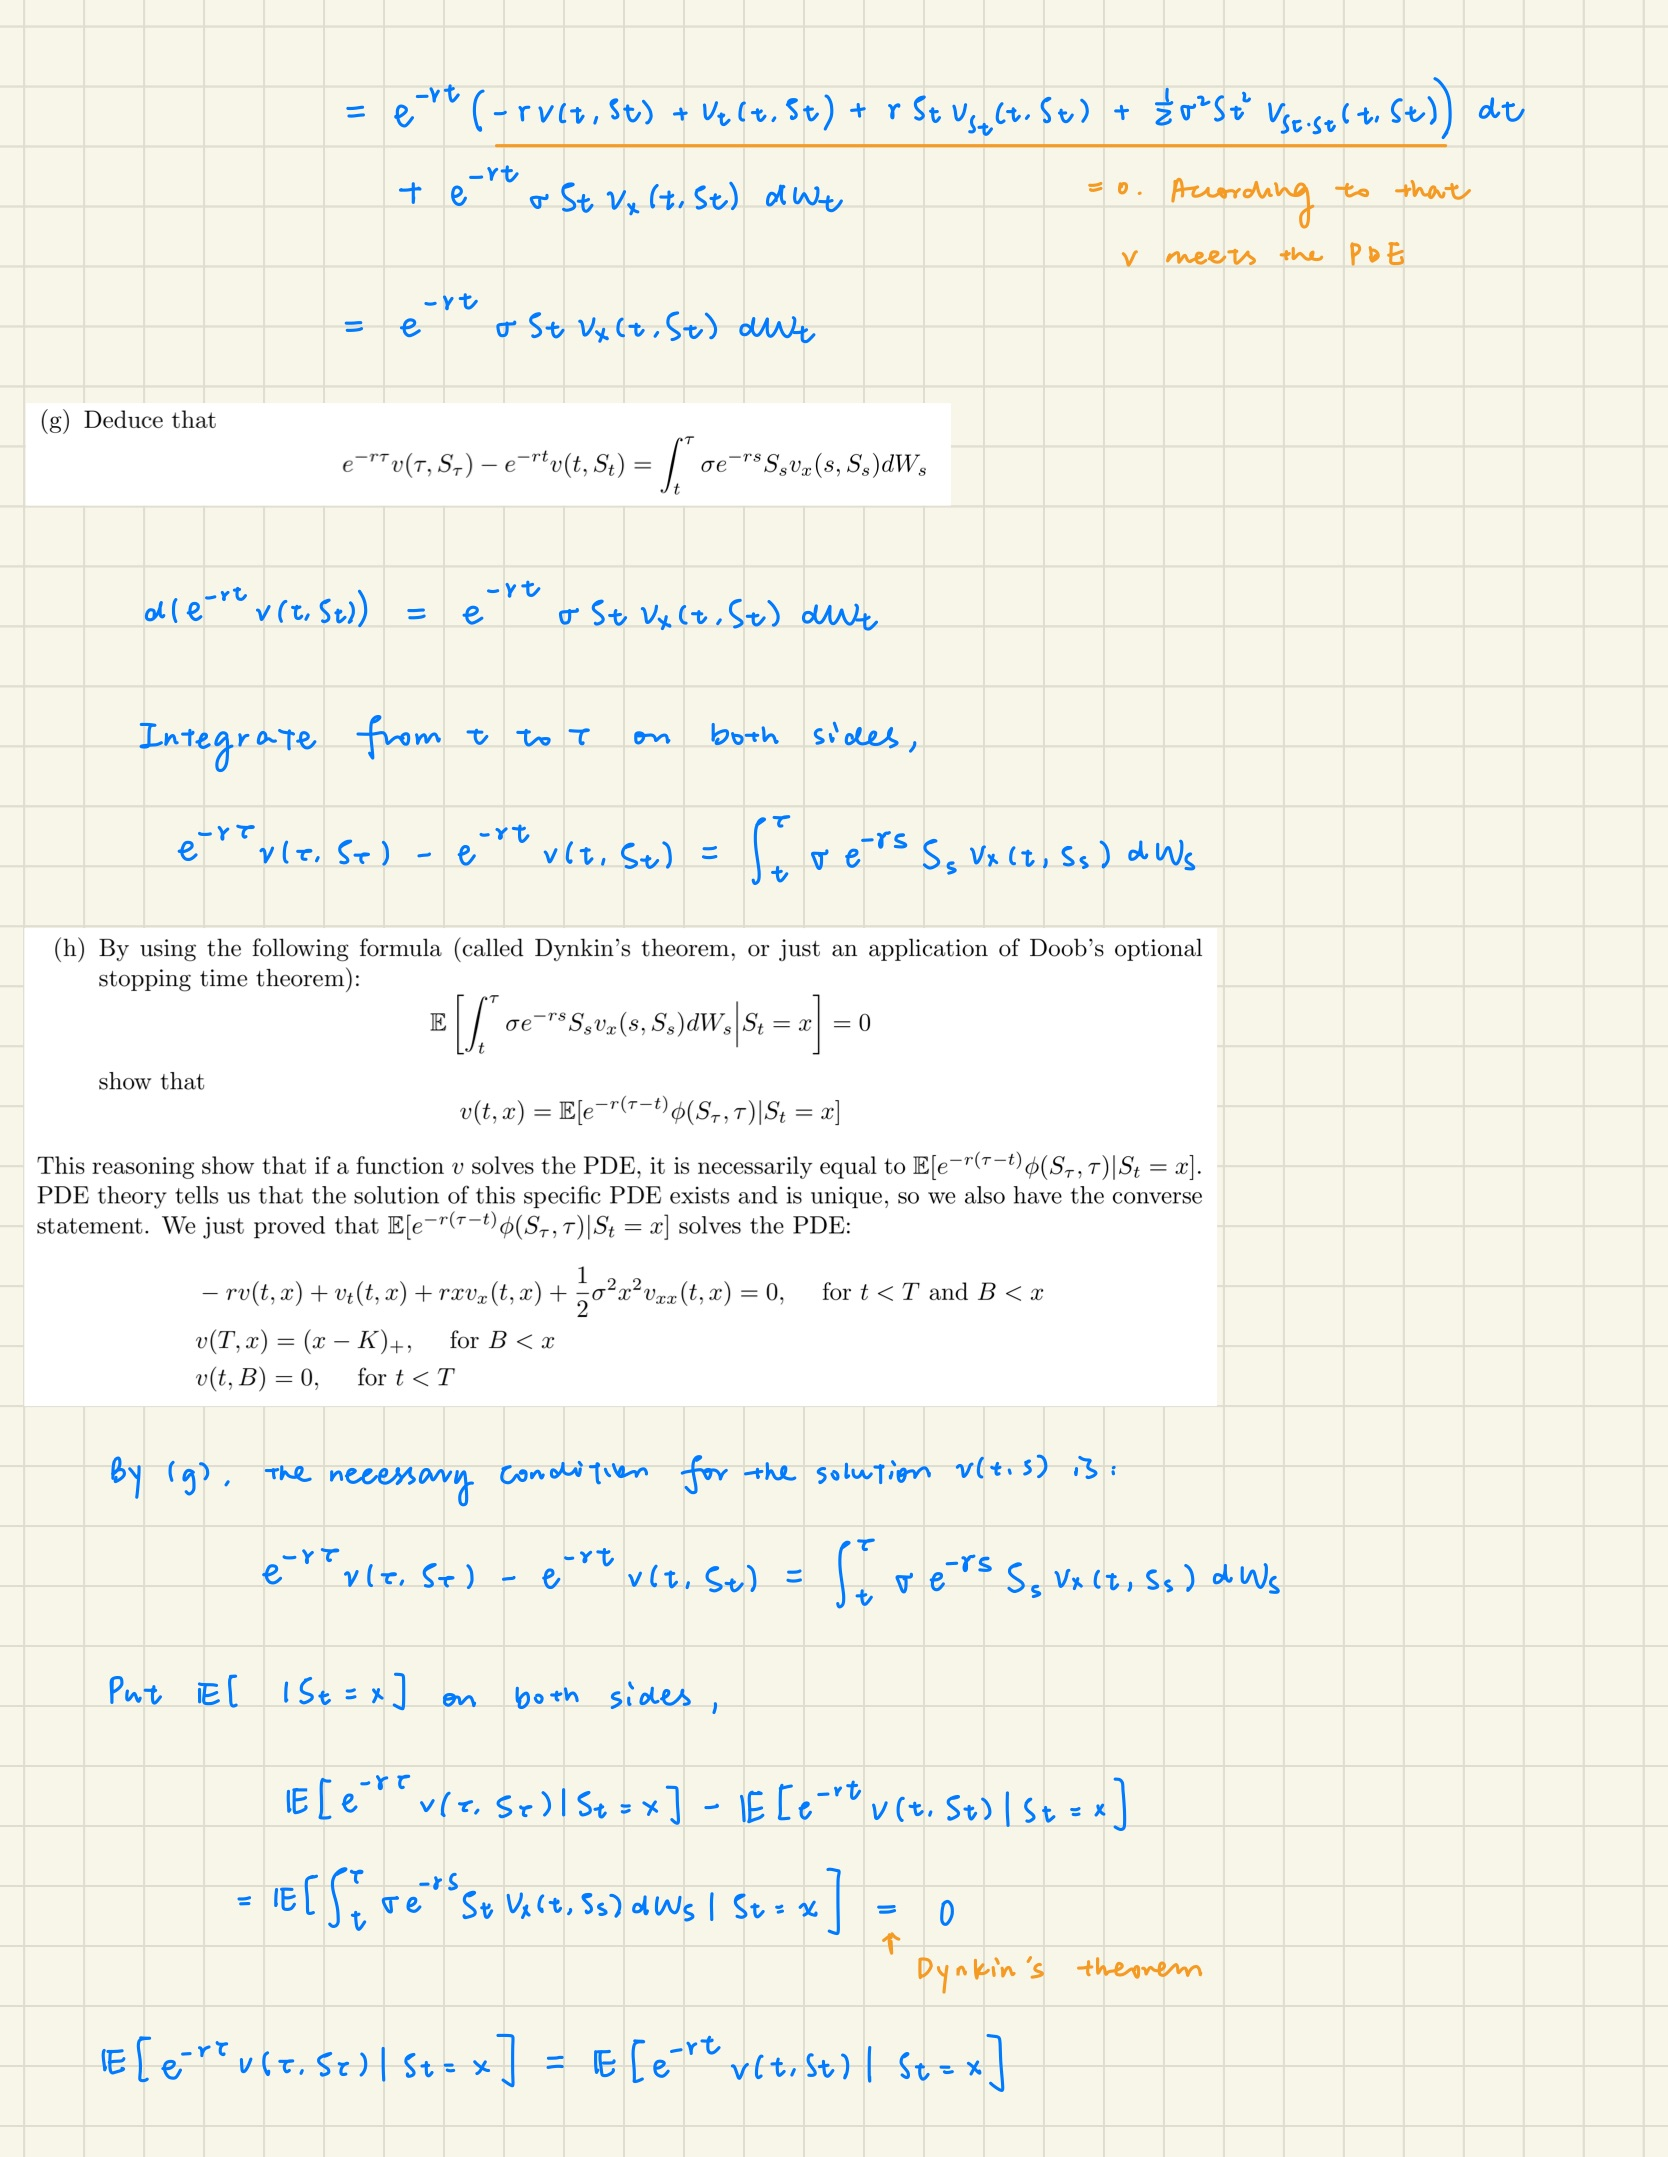

In [3]:
Image("3.jpg")

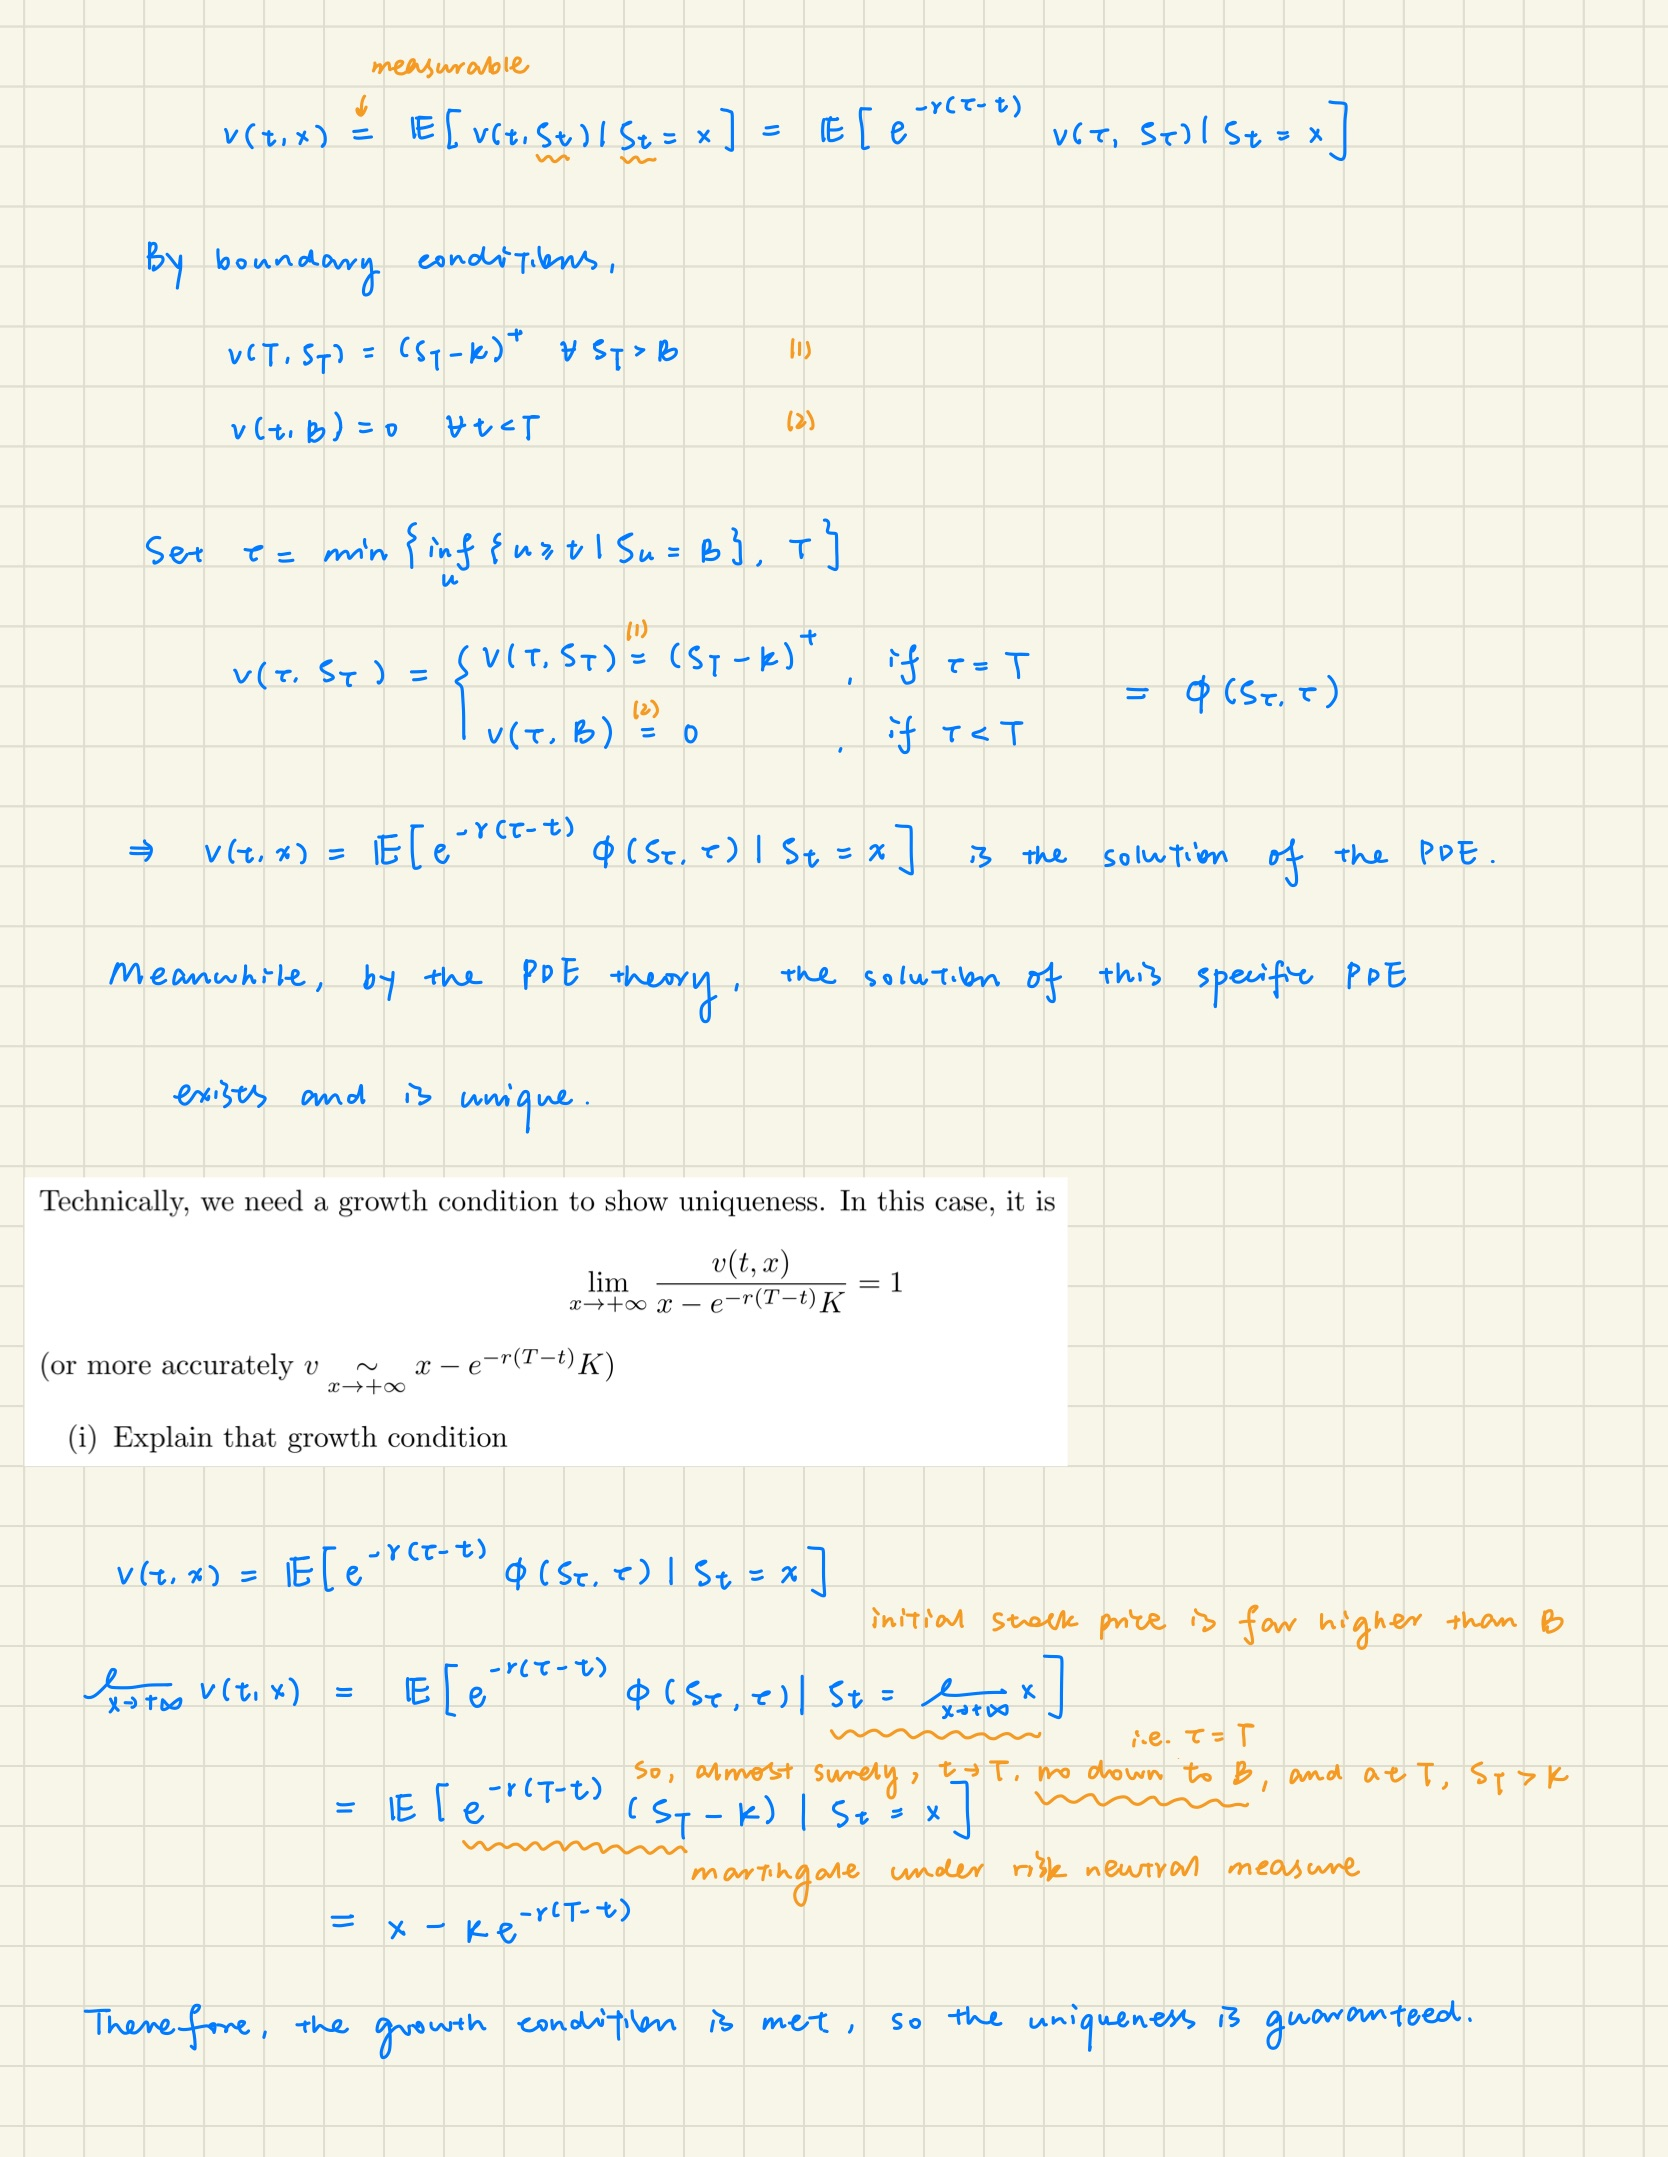

In [4]:
Image("4.jpg")

# <span style="color:blue">Method 2: Finite Difference method of PDE </span>

## <span style="color:blue">(j)~(l)</span>

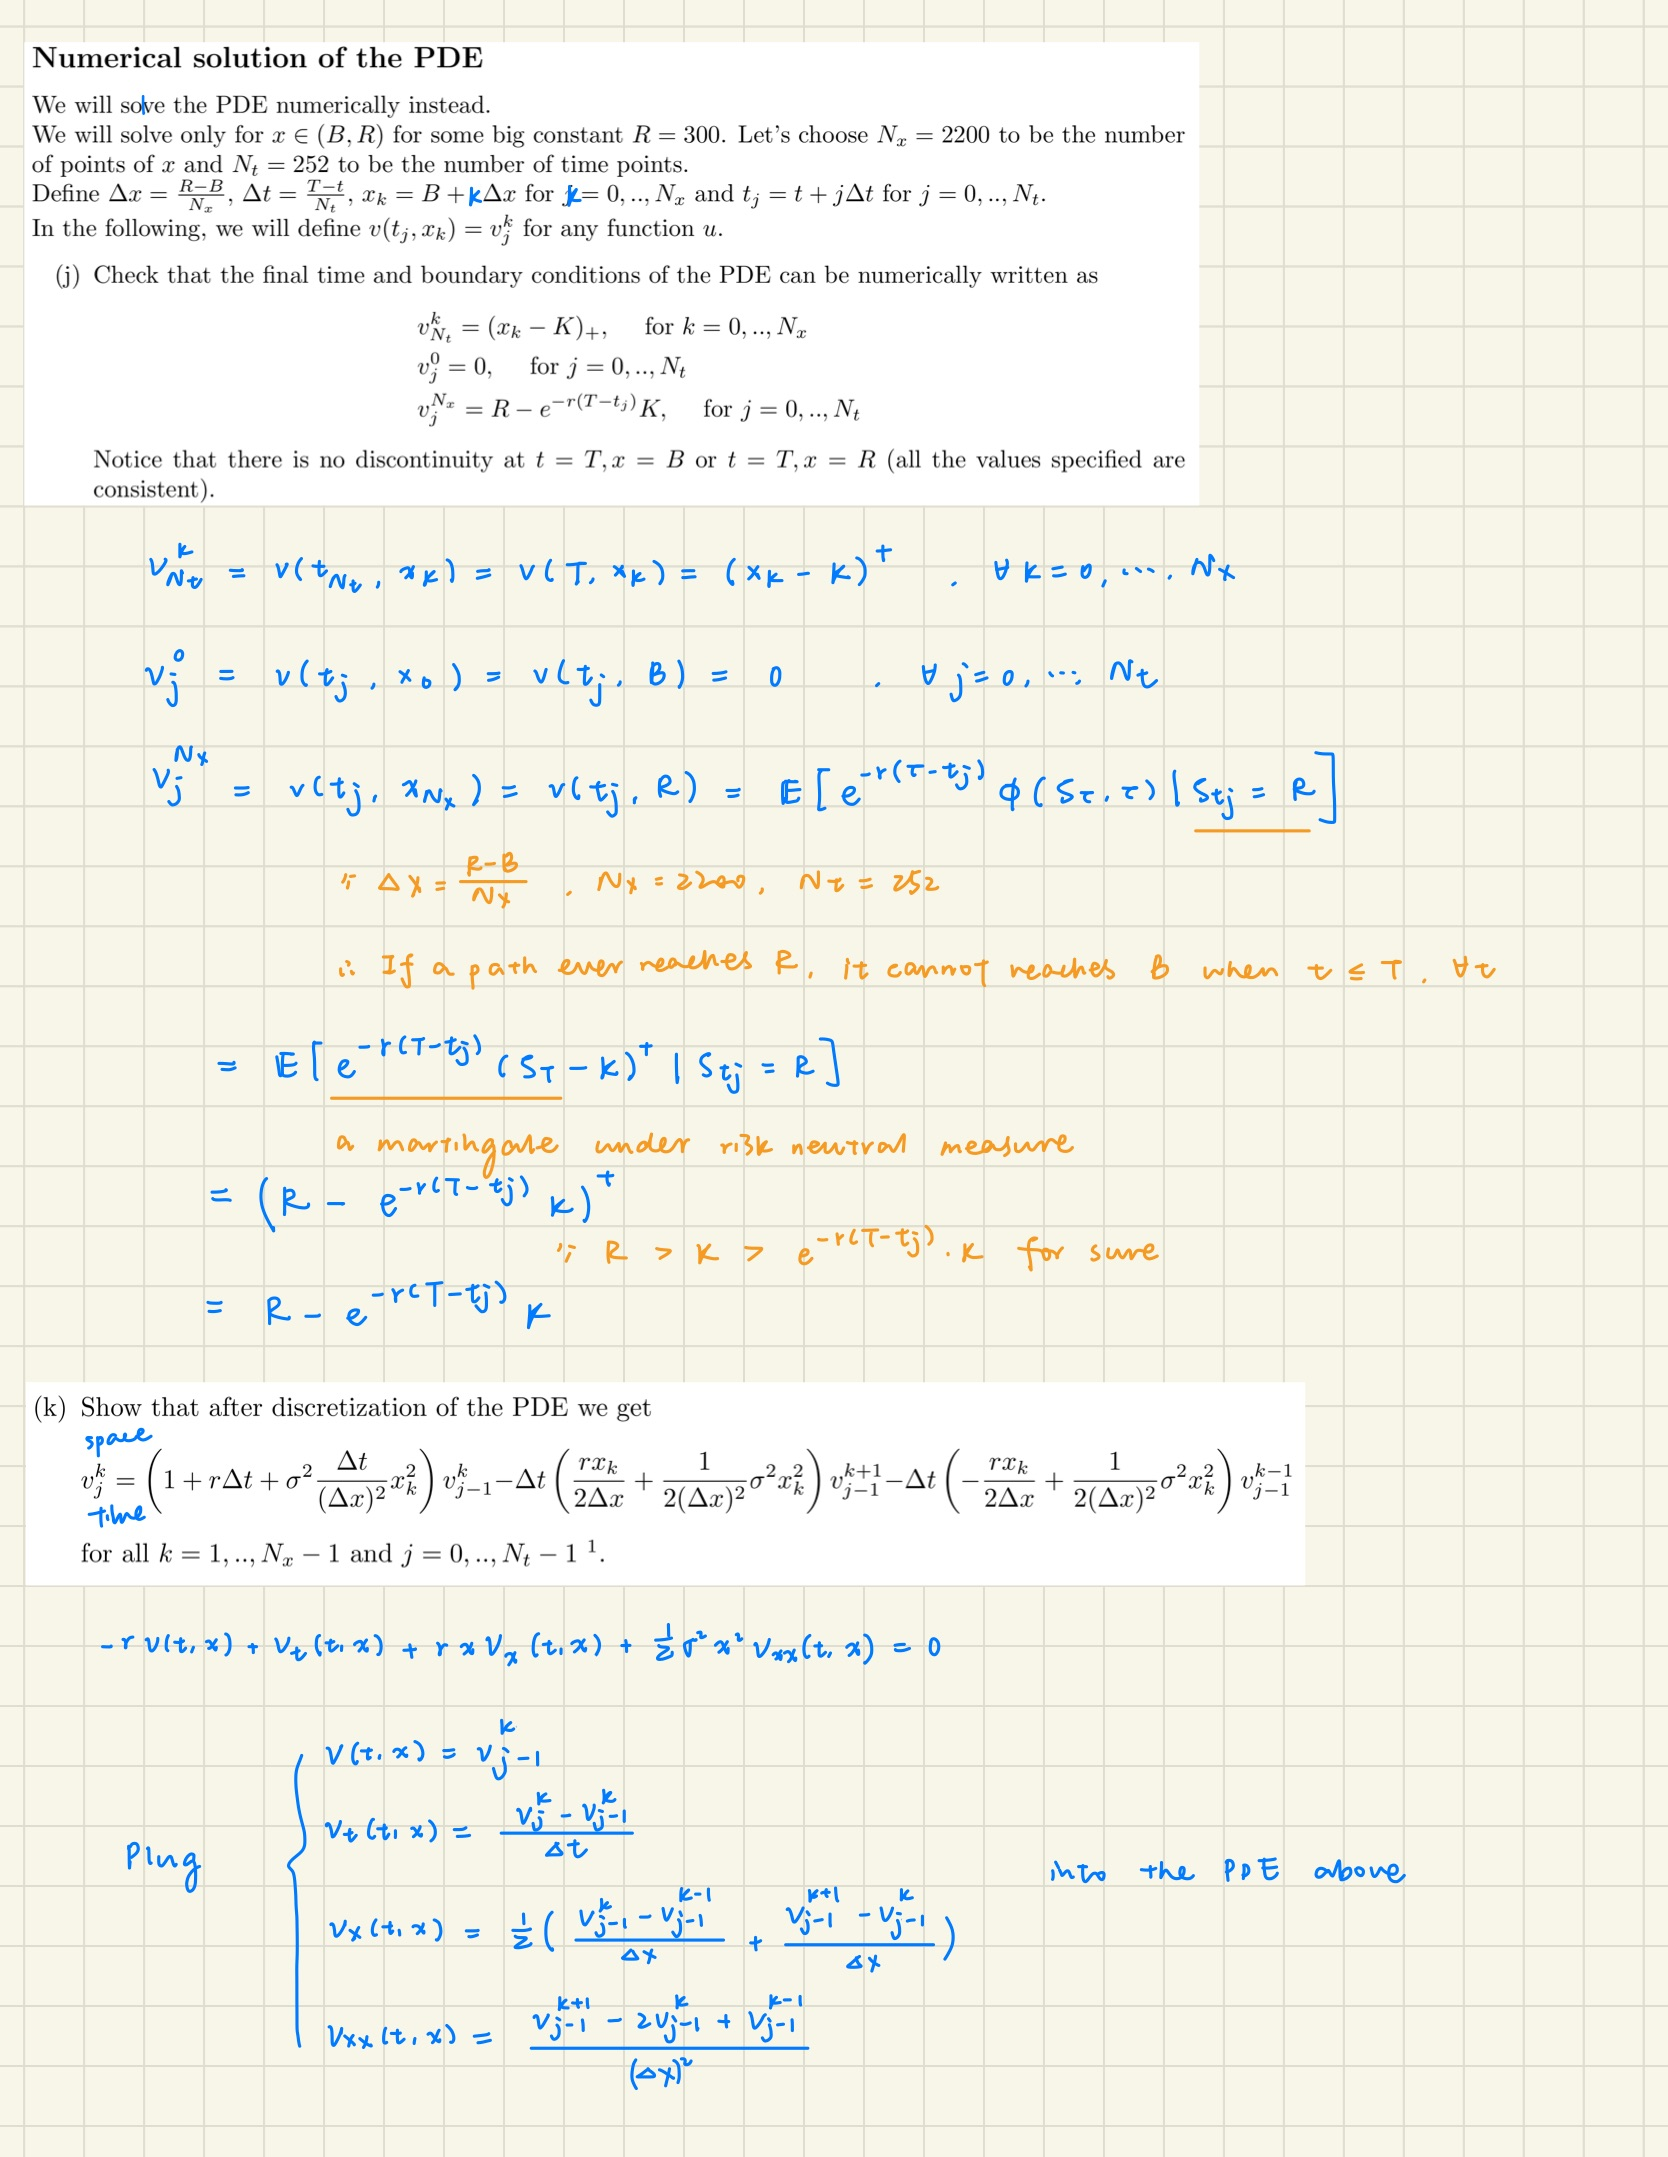

In [5]:
Image("5.jpg")

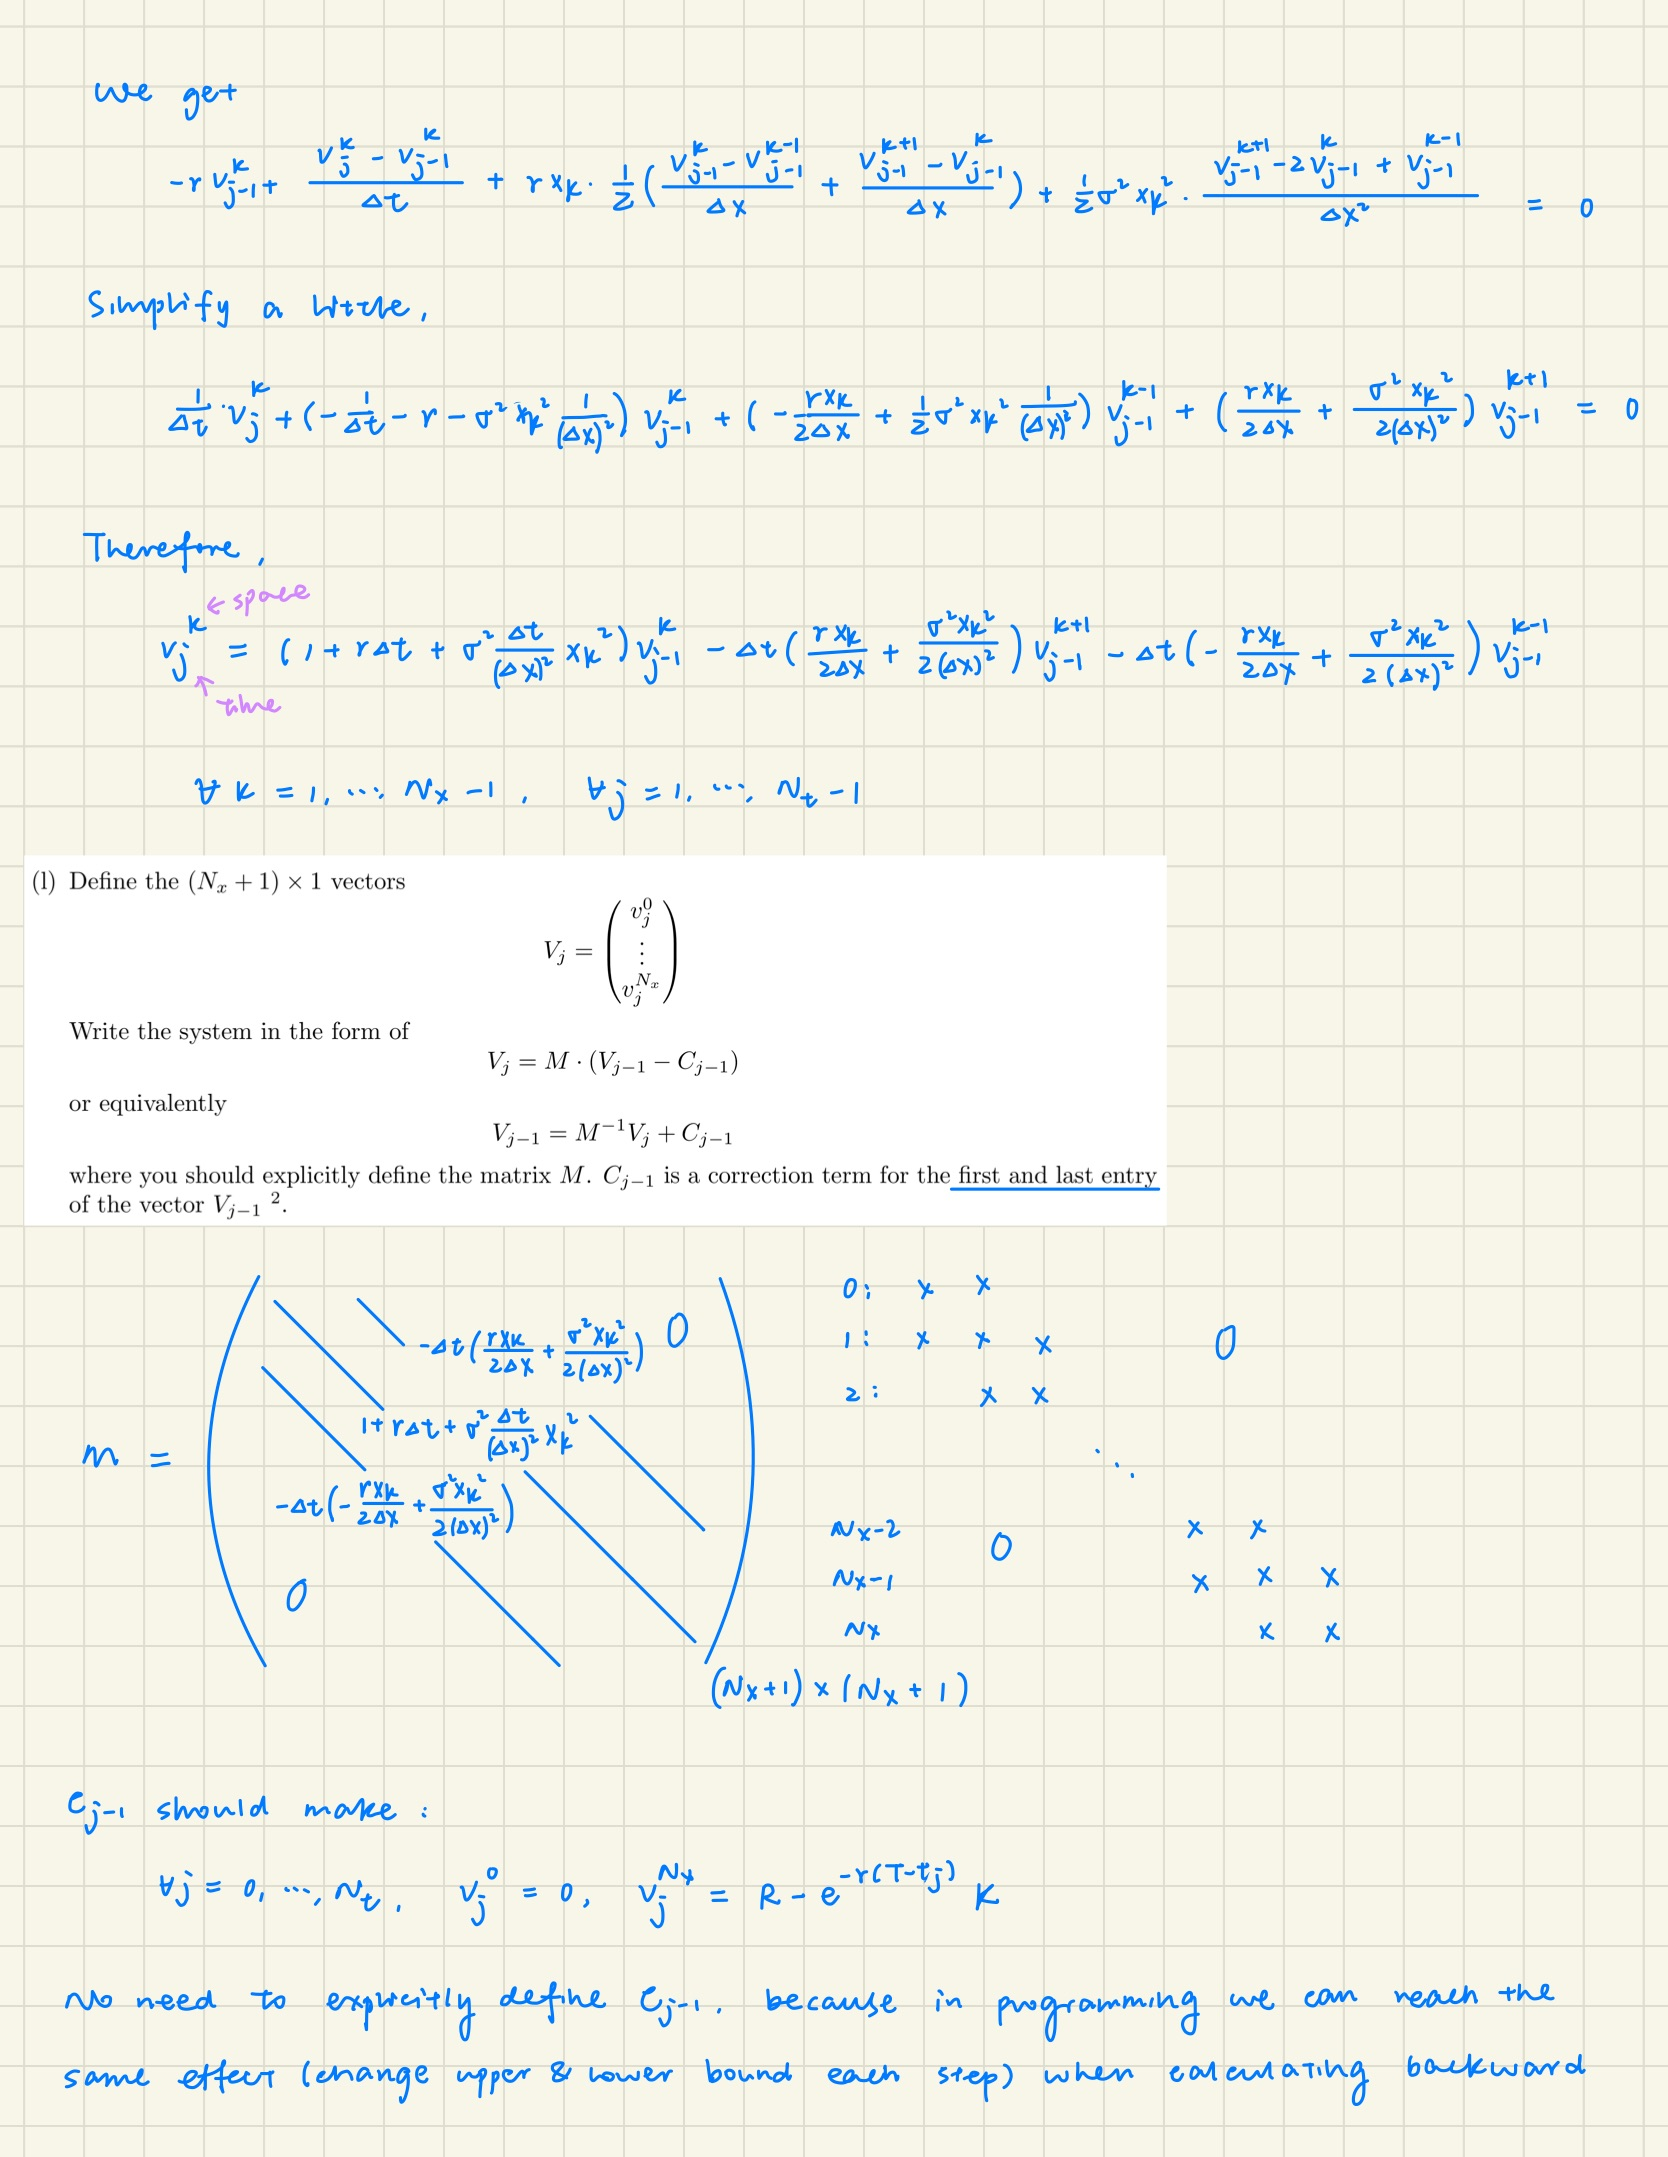

In [19]:
Image("6.jpg")

## <span style="color:blue">(m)</span>

### <span style="color:blue">Write a program that computes $V_0$ if the initial price is $100\$$.</span>

In [58]:
start_time = time.time()

delta_t = (1-0)/252
t_grid = [0+delta_t*i for i in range(253)]

delta_x = (300-80)/2200
x_grid = [80+delta_x*i for i in range(2201)]
# x_grid[200] is x = 100.0

r = 0.02
sigma = 0.2



# Setting up M
row0 = [1+r*delta_t+delta_t*(sigma*x_grid[0]/delta_x)**2, 
     -delta_t/2*(r*x_grid[0]/delta_x+(sigma*x_grid[0]/delta_x)**2)]
row0 = row0 +[0]*(2200-1)
M = []
M.append(row0)

for k in range(1,2200):
    row = [0]*(k-1)
    row = row+[-delta_t/2*(-r*x_grid[k]/delta_x+(sigma*x_grid[k]/delta_x)**2),
               1+r*delta_t+delta_t*(sigma*x_grid[k]/delta_x)**2, 
               -delta_t/2*(r*x_grid[k]/delta_x+(sigma*x_grid[k]/delta_x)**2)]
    row = row+[0]*(2200-k-1)
    M.append(row)
row2200 = [0]*(2200-1)+[-delta_t/2*(-r*x_grid[2200]/delta_x+(sigma*x_grid[2200]/delta_x)**2),
                        1+r*delta_t+delta_t*(sigma*x_grid[2200]/delta_x)**2]
M.append(row2200)

M = np.array(M)

M_inv = np.linalg.inv(M)



T = 1
K = 110
R = 300


# Calculating V price series
v = [max(x_grid[k]-K,0) for k in range(2200+1)]
v = np.array(v)

for j in range(251,-1,-1):
    v = M_inv @ v
    v[0] = 0
    v[-1] = R - np.exp(-r*(T-t_grid[j]))*K

print(v)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Running time: {elapsed_time} second")

[0.00000000e+00 3.20367745e-02 4.81854351e-02 ... 7.59315756e-01
 5.95619414e-01 1.92178146e+02]
Running time: 0.47319602966308594 second


x = 100 corresponds to the 200th element in x_grid

In [56]:
x_grid[200]

100.0

Therefore, when $S_t = x = 100$, the option price is:

In [59]:
v[200]

4.917675879166465

__Calculation result:__

__The solution by Finite Difference Method is around 4.9177. It is a fixed number, given all these parameters.__

__Running time:__

__Very fast, taking around 0.47 seconds.__

# <span style="color:blue">Method 3: Closed-form analytical method of PDE </span>

## <span style="color:blue">(n)</span>

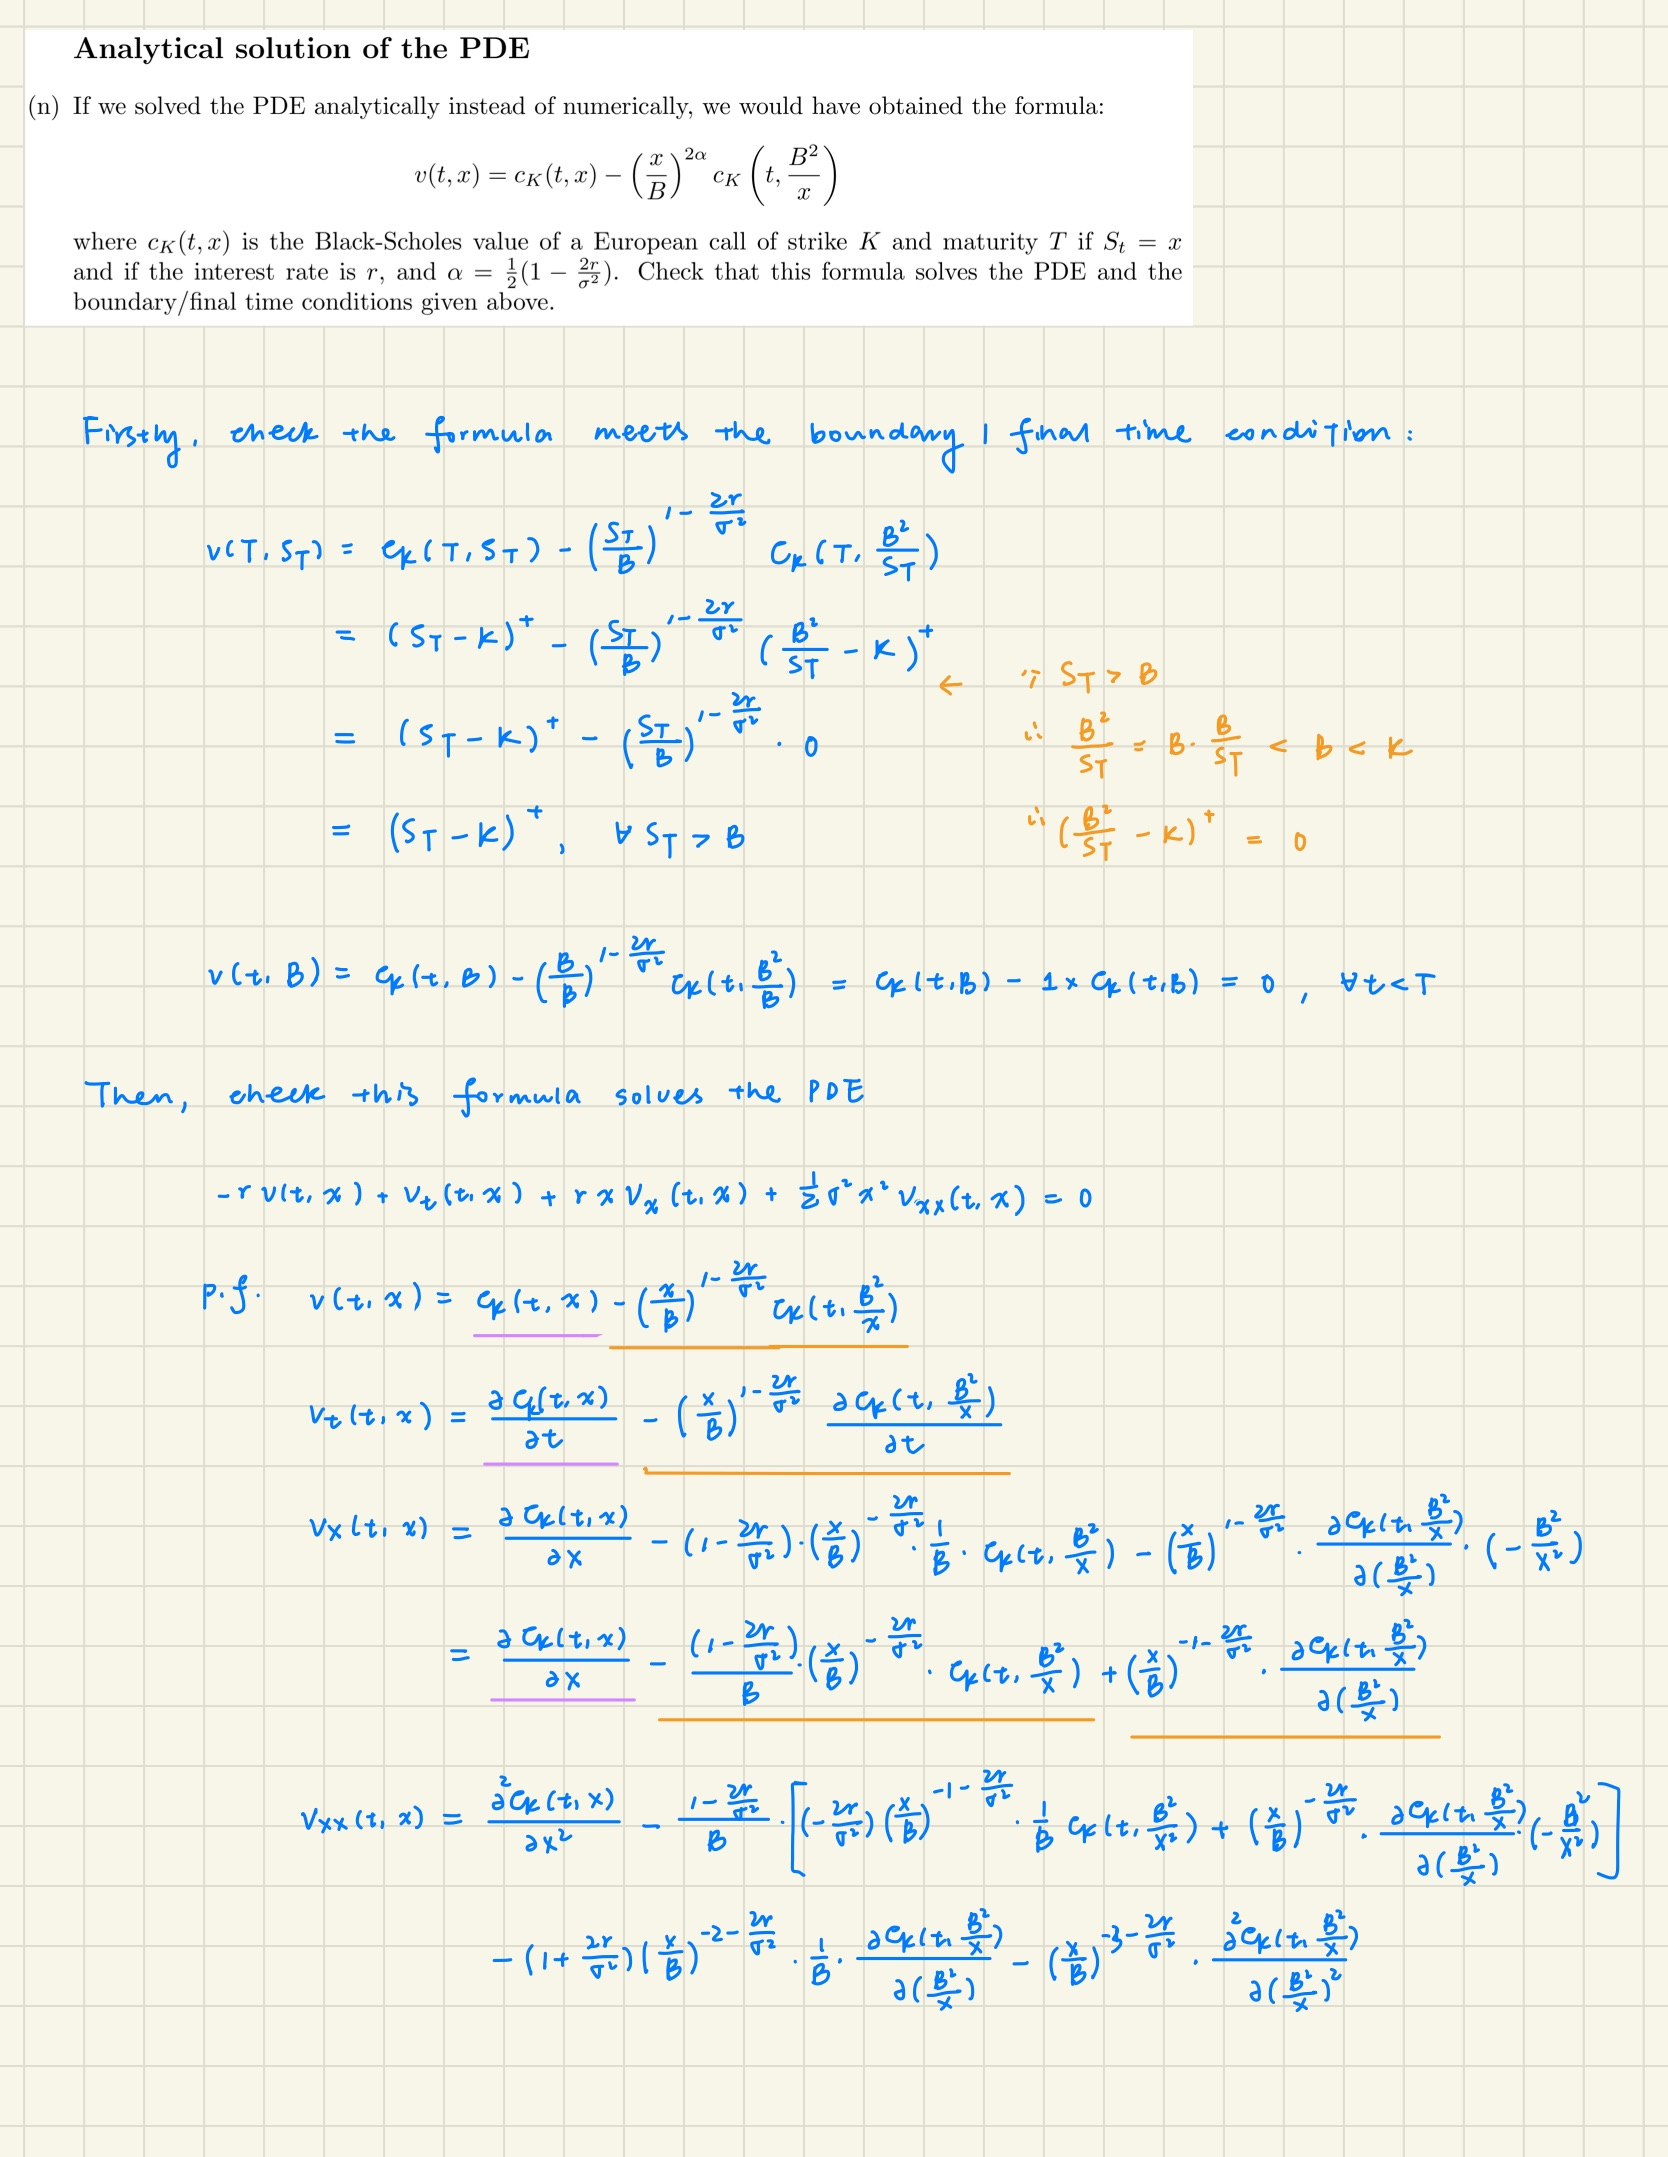

In [7]:
Image("7.jpg")

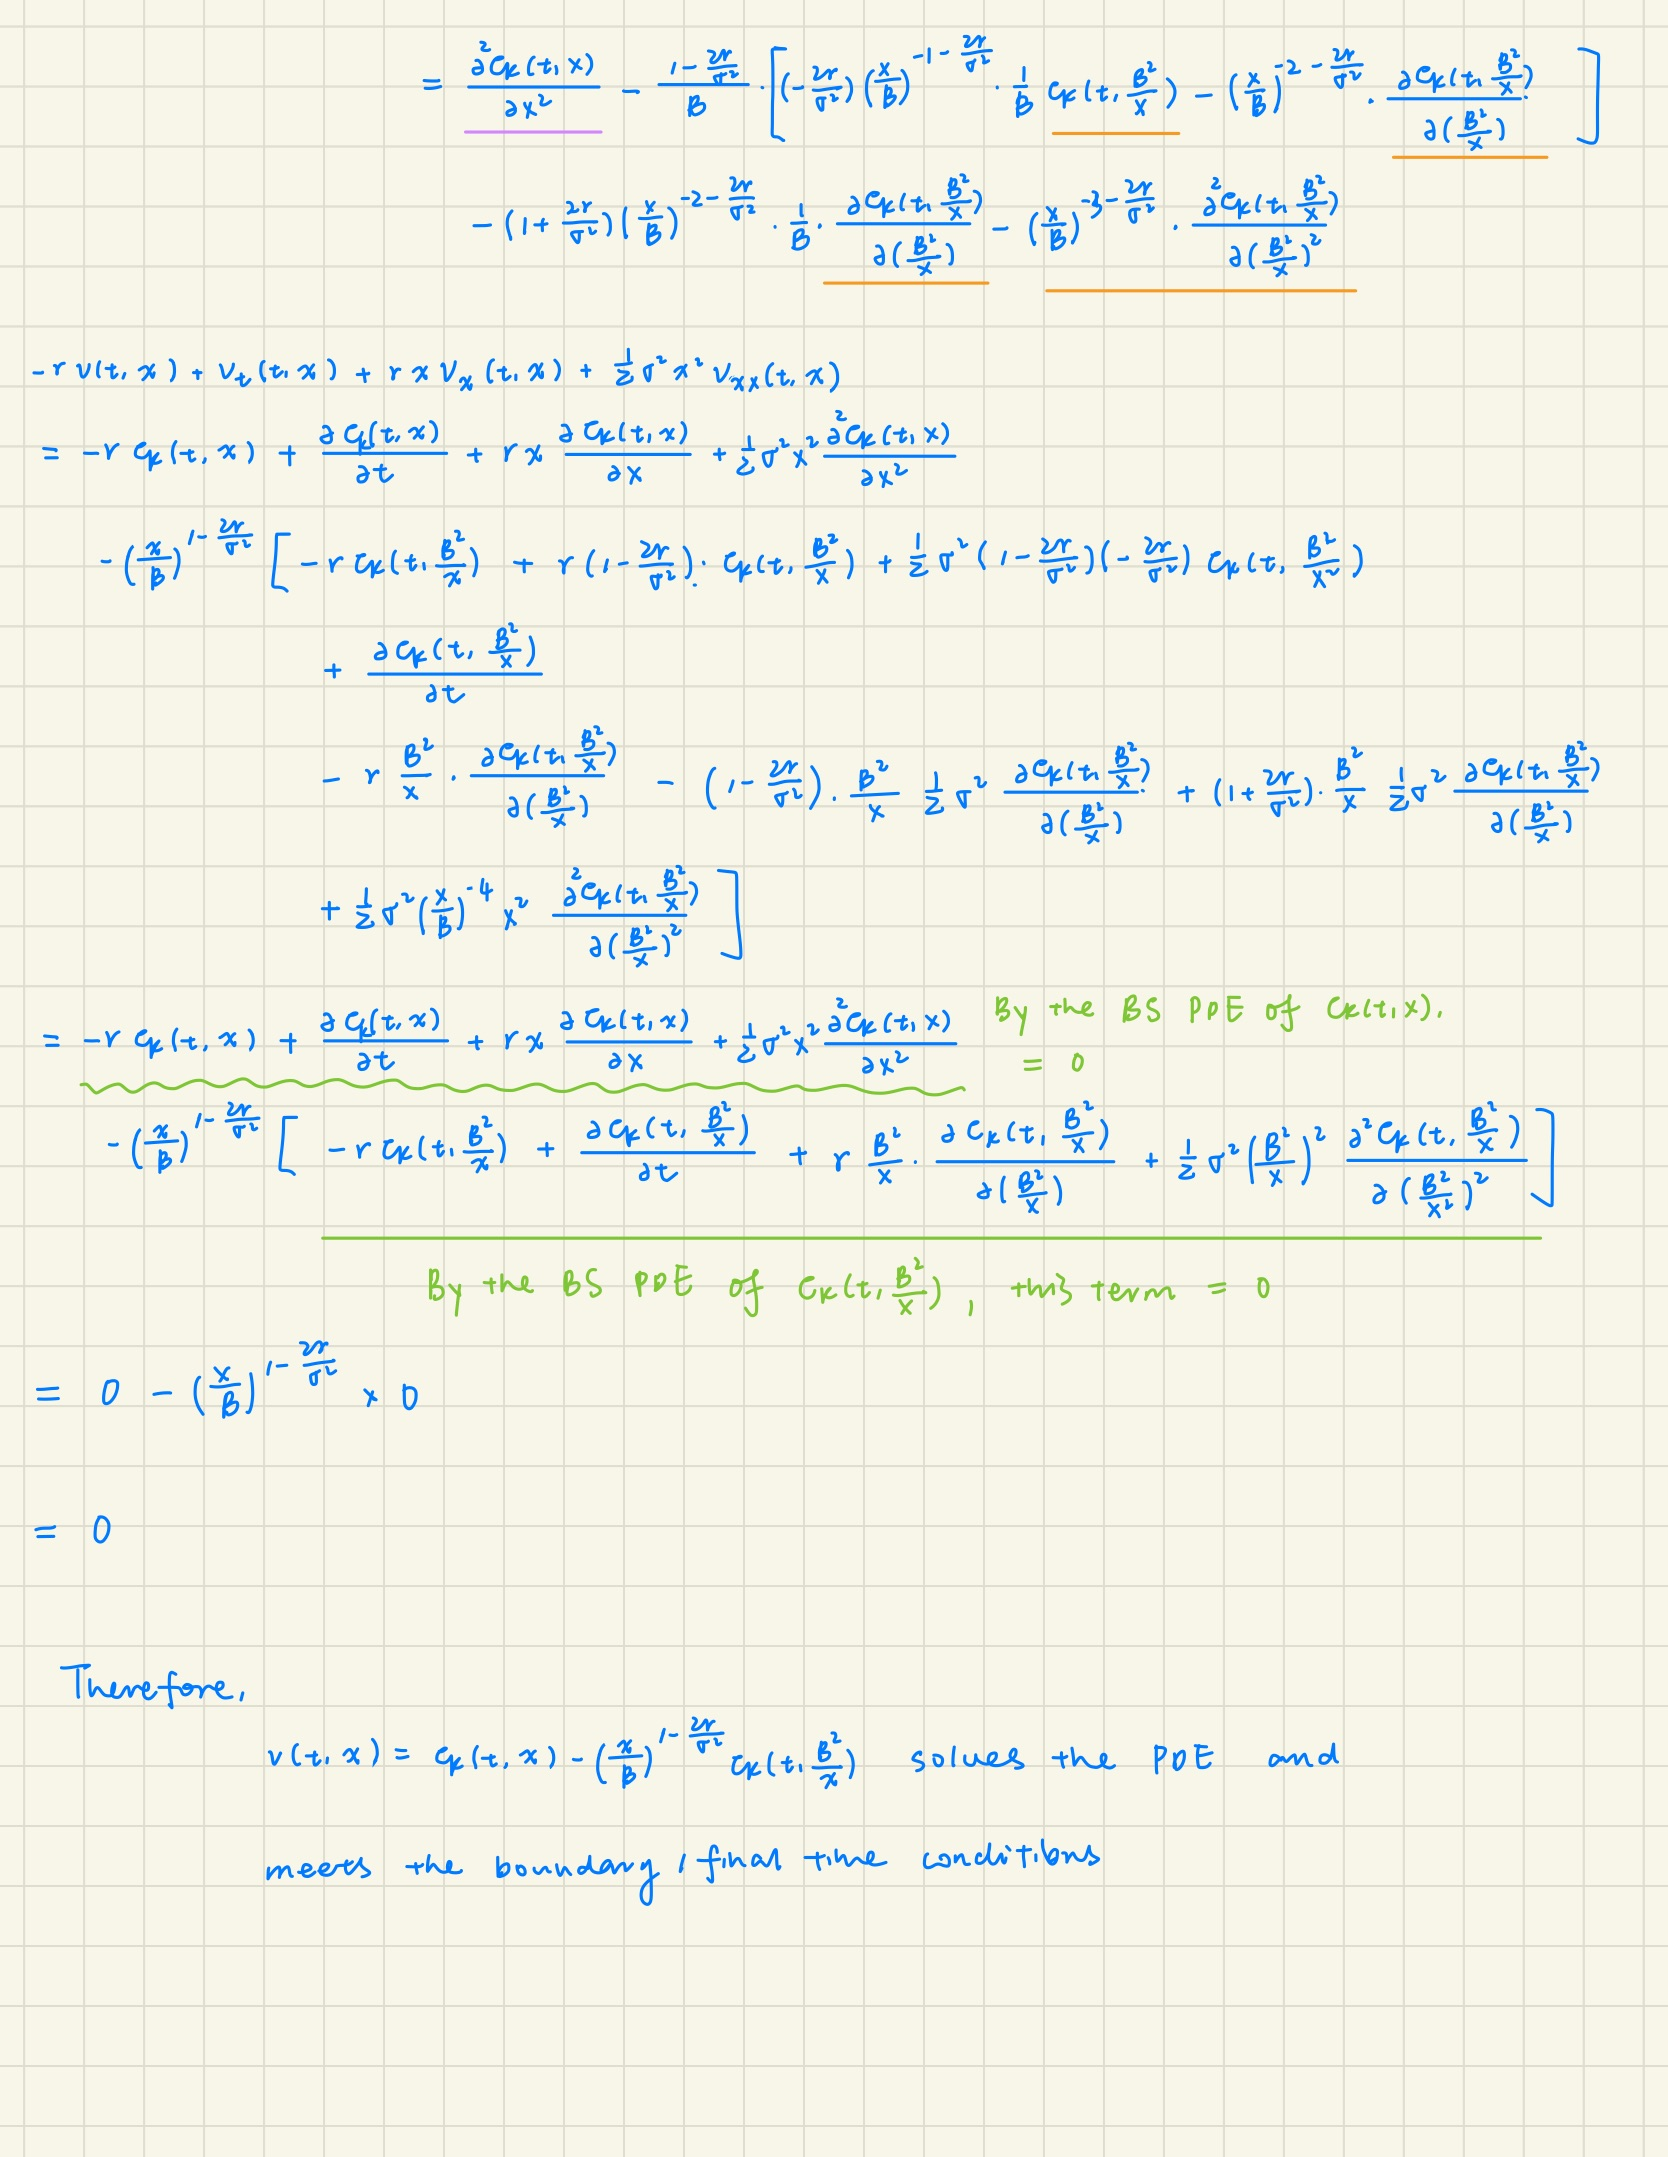

In [8]:
Image("8.jpg")

## <span style="color:blue">(o)</span>

### <span style="color:blue">Compare the prices (accuracy and speed) obtained numerically by Monte Carlo and the PDE method, with theoretical price from the PDE.</span>

$$
v(t,x) = c_K(t,x) - (\frac{x}{B})^{2\alpha}c_K(t,\frac{B^2}{x})
$$

where $c_K(t,x)$ is the BS European call of strike $K$ and maturity $T$ if $S_t = x$, interest rate is $r$, and $\alpha = \frac{1}{2}(1-\frac{2r}{\sigma^2})$

In [60]:
def EurCall(t,T,r,sigma,x,K):
    from scipy.stats import norm
    d1 = (np.log(x/K)+(r+sigma**2/2)*(T-t))/(sigma*np.sqrt(T-t))
    d2 = (np.log(x/K)+(r-sigma**2/2)*(T-t))/(sigma*np.sqrt(T-t))
    premium = x*norm.cdf(d1)-K*np.exp(-r*(T-t))*norm.cdf(d2)
    return premium

In [61]:
# example
EurCall(0,1,0.02,0.2,100,110)

4.94386695723049

In [62]:
def Analytical(t,T,r,sigma,x,B,K):
    return EurCall(t,T,r,sigma,x,K)-(x/B)**(1-2*r/(sigma**2))*EurCall(t,T,r,sigma,B**2/x,K)

In [64]:
start_time = time.time()

print('The price by analytical method is:', Analytical(0,1,0.02,0.2,100,80,110))

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Running time: {elapsed_time} seconds")

The price by analytical method is: 4.920256808220372
Running time: 0.0013041496276855469 seconds


__Calculation result:__

__The analytical solution of the PDE is around 4.9203. It is a fixed number, given all these parameters.__

__Running time:__

__Very fast, taking around 0.0013 seconds.__

# <span style="color:blue">Conclusions:</span>

### Accuracy:

 - The Monte Carlo solution of the PDE is around 4.93. Since it is an average, expected, present value of multiple times of simulation, the result is a not fixed number.
 - The Finite Difference solution is around 4.9177. It is a fixed number, given all these parameters.
 - The PDE's analytical solution is around 4.9203. It is a fixed number, given all these parameters.
 
Therefore, Compare Monte Carlo solution method and Finite Difference method, with the analytical method as a basis:

Monte Carlo method and Finite Difference method have similar accuracy, while the Finite Difference method is much more stable.

### Running Speed:

 - The Monte Carlo simulation method needs 170 seconds.
 - The Finite Difference method needs 0.47 seconds.
 - The PDE's analytical method only needs 0.0013 seconds.
 
Monte Carlo method does a far worse job in terms of speed, while analytical method does the fast job.

### Similarity:

These 3 results are all pretty close, around 4.92. This shows the correctness and consistency of all the 3 methods.

### Difference:

1. Only the analytical solution is the precise solution. The 2 solutions by Monte Carlo and Finite Difference only offer the numerical solutions, which are approximate.

2. The 2 solutions from Finite Difference and analytical method are fixed, while the solution by Monte Carlo changes in each time of simulation, but it converges.

### <center><span style="color:blue">END</span><center>